# Data Source

Airport Dataset : https://www.kaggle.com/jinbonnie/airport-information
<br>
Flights Route Dataset : https://www.kaggle.com/open-flights/flight-route-database

# Project's Description

The goal of this simple project is to visualize flight route and airport data using pydeck package. Pydeck package is a python package (derived from deck.gl) that mainly used to create pretty visualization of geospatial data. This project also help me to familiarize using pydeck as one of visualization library in Python.
<br>
<br>
For more information about pydeck, check the documentation here: https://deckgl.readthedocs.io/en/latest/

# Import Modules

In [1]:
import numpy as np
import pandas as pd
import pydeck as pdk
from dotenv import load_dotenv
import os
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
load_dotenv()

True

# Load Dataset

In [3]:
df_airport = pd.read_csv('airport-information/airport_code.csv')
df_route = pd.read_csv('flight-route-database/routes.csv')

In [4]:
display(df_airport.sample(5))
display(df_route.sample(5))

id    ident           type              name  latitude_deg  \
49972   32418     SYMN  small_airport    Manari Airport      3.433000   
57747   38644     YWIL  small_airport  Wilandra Airport    -31.283300   
50463   25017     TS00  small_airport    Fuller Airport     32.788200   
52168  324705  US-0616  small_airport  Flying M Airport     34.002175   
51255   44610     UHMN  small_airport    Omolon Airport     65.239998   

       longitude_deg  elevation_ft continent iso_country iso_region  \
49972     -59.567001         300.0        SA          GY      GY-UT   
57747     142.667007           NaN        OC          AU     AU-NSW   
50463     -97.180801         490.0       NaN          US      US-TX   
52168     -96.770147         807.0       NaN          US      US-OK   
51255     160.539993           NaN        AS          RU     RU-CHU   

      municipality scheduled_service gps_code local_code  
49972       Manari                no     SYMN        NaN  
57747          NaN                no     YWIL        NaN  
50463   Fort Worth                no     TS00       TS00  
52168     Kingston                no     12OK       12OK  
51255       Omolon               yes     UHMN        NaN

airline airline ID  source airport  source airport id  \
7880       AC        330             DKR               1084   
22505      DY       3737             LGW                502   
26234      FR       4296             BRS                490   
55131      U2       2297             MAD               1229   
45877      PK       3871             LHE               2207   

       destination apirport  destination airport id  codeshare   stops  \
7880                    BRU                     302          Y       0   
22505                   ACE                    1055        NaN       0   
26234                   LIG                    1270        NaN       0   
55131                   SXF                     337        NaN       0   
45877                   RUH                    2082        NaN       0   

       equipment  
7880         333  
22505        73H  
26234        738  
55131    320 319  
45877        310

# Data Preprocessing

Before creating visualization, it's better to do data preprocessing first. Let's start it with checking the null values.

In [5]:
df_airport.info()
df_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58505 entries, 0 to 58504
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 58505 non-null  int64  
 1   ident              58505 non-null  object 
 2   type               58505 non-null  object 
 3   name               58505 non-null  object 
 4   latitude_deg       58505 non-null  float64
 5   longitude_deg      58505 non-null  float64
 6   elevation_ft       50054 non-null  float64
 7   continent          29530 non-null  object 
 8   iso_country        58259 non-null  object 
 9   iso_region         58505 non-null  object 
 10  municipality       52634 non-null  object 
 11  scheduled_service  58505 non-null  object 
 12  gps_code           41709 non-null  object 
 13  local_code         30482 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67663 entr

Look's like there are several columns with null values, but those columns will not be used for this visualization project so we can leave the null values as it is. Now, it's little bit harder to check the null values based on the raw number above, don't you think? Let's try to count the percentage missing values and visualize the missing values data to be able get quick grasp about how many missing value in our data

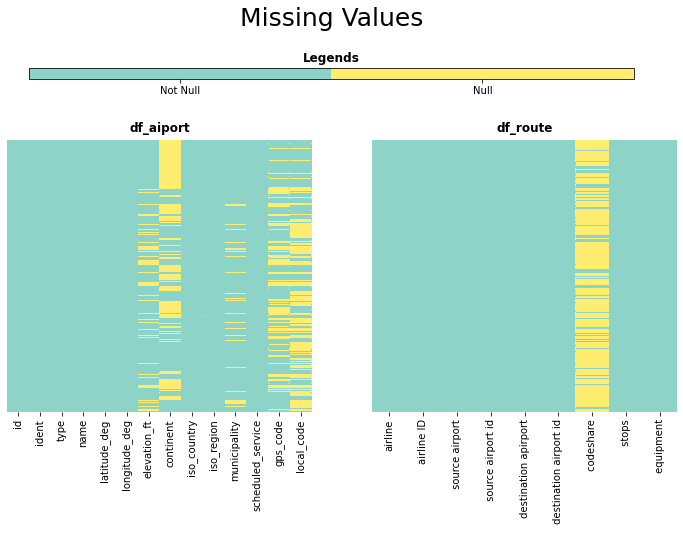

In [6]:
# Create figure and axes, also set the title figure and adjust the distance between plots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
plt.subplots_adjust(wspace=0.2)
plt.suptitle('Missing Values', y=1.25, fontsize=25)

# Define colors, since the value is only True/False, we only need two color for matplotlib palette `Set3`
colors = plt.get_cmap('Set3', 2)

# Create plot for each dataframe
for idx, df in enumerate([df_airport, df_route]):
    main_plot = sns.heatmap(df.isnull(), yticklabels=False,
                            cmap=colors, ax=ax[idx], cbar=False)

# Create colorbar for all plots
cax = fig.add_axes([0.15, 1.05, 0.7, 0.03])
sm = matplotlib.cm.ScalarMappable(cmap=colors)
cbar = fig.colorbar(sm, ax=ax, cax=cax, orientation='horizontal')

# Configure the ticklabels and title for colorbar
cbar.ax.set_title('Legends', fontweight='bold')
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(['Not Null', 'Null'])

# Set plot title
ax[0].set_title('df_aiport', fontweight='bold', y=1.01)
ax[1].set_title('df_route', fontweight='bold', y=1.01)

# Show plot
plt.show()

Great! If you may notice, some of the column in `df_route` has leading white space. We'll need to fix that for the sake of convience.

In [7]:
df_route.columns = list(map(str.strip, df_route.columns))
df_route.columns

Index(['airline', 'airline ID', 'source airport', 'source airport id',
       'destination apirport', 'destination airport id', 'codeshare', 'stops',
       'equipment'],
      dtype='object')

Next, we need to merge two dataframes so we can get dataframe with latitude and longitude for both source airport and destination airport. We will use `pandas.merge` function to achieve this task and use `id` column from `df_airport` and `source airport id`, `destination airport id` from `df_route` to match with. But, first, we need to change the datatype since those have different datatype. Here, I choose to change the `id` column from integer to string datatype so it can retain more information even though we change the datatype.

In [8]:
df_airport['id'] = df_airport['id'].astype(str)

In [9]:
merge1 = pd.merge(df_route, df_airport, left_on='source airport id', right_on='id')
df_route_airport = pd.merge(merge1, df_airport, left_on='destination airport id', right_on='id', suffixes=('_source', '_destination'))
df_route_airport

airline airline ID source airport source airport id  \
0          2B        410            AER              2965   
1          2B        410            ASF              2966   
2          2B        410            CEK              2968   
3          2B        410            DME              4029   
4          S7       4329            DME              4029   
...       ...        ...            ...               ...   
65308      YN         \N            YNC              5516   
65309      YN         \N            YPO              5522   
65310      YN         \N            ZKE              5543   
65311      ZL       4178            JCK              6276   
65312      ZL       4178            TRO              6794   

      destination apirport destination airport id codeshare  stops equipment  \
0                      KZN                   2990       NaN      0       CR2   
1                      KZN                   2990       NaN      0       CR2   
2                      KZN                   2990       NaN      0       CR2   
3                      KZN                   2990       NaN      0       CR2   
4                      KZN                   2990       NaN      0       319   
...                    ...                    ...       ...    ...       ...   
65308                  ZEM                   5539       NaN      0       DH8   
65309                  YAT                   5482       NaN      0       DH1   
65310                  YAT                   5482       NaN      0       DH1   
65311                  RCM                   9904       NaN      0       SF3   
65312                  GFN                   6792       NaN      0       SF3   

      id_source  ... latitude_deg_destination longitude_deg_destination  \
0          2965  ...                -7.004780                 52.726200   
1          2966  ...                -7.004780                 52.726200   
2          2968  ...                -7.004780                 52.726200   
3          4029  ...                -7.004780                 52.726200   
4          4029  ...                -7.004780                 52.726200   
...         ...  ...                      ...                       ...   
65308      5516  ...                34.371451                132.417666   
65309      5522  ...                28.274000                 69.276001   
65310      5543  ...                28.274000                 69.276001   
65311      6276  ...                64.042000               -148.863007   
65312      6794  ...                30.270262                -97.745275   

      elevation_ft_destination  continent_destination  \
0                         10.0                     AF   
1                         10.0                     AF   
2                         10.0                     AF   
3                         10.0                     AF   
4                         10.0                     AF   
...                        ...                    ...   
65308                     15.0                     AS   
65309                    250.0                     AS   
65310                    250.0                     AS   
65311                   2817.0                    NaN   
65312                    540.0                    NaN   

       iso_country_destination  iso_region_destination  \
0                           SC                   SC-15   
1                           SC                   SC-15   
2                           SC                   SC-15   
3                           SC                   SC-15   
4                           SC                   SC-15   
...                        ...                     ...   
65308                       JP                   JP-34   
65309                       PK                   PK-SD   
65310                       PK                   PK-SD   
65311                       US                   US-AK   
65312                       US                   US-TX   

      municipality_destinatio

In the merged dataframe above, we merge the `df_route` and `df_airport` two times because we need the airport information for source airport and destination airport. The source airport data's columns will have suffix of '\_source' while the destination airport will have suffix of '\_destination'. 

As you can see, the route data has many records with total of 65313. In this project, we will limit the visualization data since our main focus is to create geospatial viz using pydeck. We will filter the data only for source/destination airport type of `large airport` since we may able to recognize most of these airport.

In [10]:
# List of all airport's type available in dataset
df_airport['type'].unique()

array(['heliport', 'small_airport', 'closed', 'seaplane_base',
       'balloonport', 'medium_airport', 'large_airport'], dtype=object)

In [11]:
airport_type = ['large_airport']
source_airport = df_route_airport.type_source.isin(airport_type)
destination_airport = df_route_airport.type_destination.isin(airport_type)
df_plot = df_route_airport[source_airport & destination_airport]
df_plot

airline airline ID source airport source airport id  \
1445       UN       5067            BKK              3885   
1452       S7       4329            PEK              3364   
1453       U6       5234            PEK              3364   
1491       7R       1469            KUF              2993   
1492       UR      15814            KUF              2993   
...       ...        ...            ...               ...   
64693      LM       3287            NRL              5566   
64832      FO        476            SAH              3980   
64833      IY       5496            SAH              3980   
64909      NF        524            ULB              5910   
65141      NF        524            CCV              5897   

      destination apirport destination airport id codeshare  stops equipment  \
1445                   SVX                   2975       NaN      0       763   
1452                   SVX                   2975       NaN      0       320   
1453                   SVX                   2975       NaN      0       320   
1491                   SVX                   2975       NaN      0       CR2   
1492                   SVX                   2975       NaN      0       AT7   
...                    ...                    ...       ...    ...       ...   
64693                  EOI                   5564       NaN      0       BNI   
64832                  AAY                   3979       NaN      0       CR7   
64833                  AAY                   3979         Y      0       CR7   
64909                  CCV                   5897       NaN      0       DHT   
65141                  ULB                   5910       NaN      0   DHT YN2   

      id_source  ... latitude_deg_destination longitude_deg_destination  \
1445       3885  ...               -25.920799                 32.572601   
1452       3364  ...               -25.920799                 32.572601   
1453       3364  ...               -25.920799                 32.572601   
1491       2993  ...               -25.920799                 32.572601   
1492       2993  ...               -25.920799                 32.572601   
...         ...  ...                      ...                       ...   
64693      5566  ...                33.585899                130.451004   
64832      3980  ...                43.232101                 27.825100   
64833      3980  ...                43.232101                 27.825100   
64909      5910  ...                -3.038610                -60.049702   
65141      5897  ...               -23.435556                -46.473057   

      elevation_ft_destination  continent_destination  \
1445                     145.0                     AF   
1452                     145.0                     AF   
1453                     145.0                     AF   
1491                     145.0                     AF   
1492                     145.0                     AF   
...                        ...                    ...   
64693                     32.0                     AS   
64832                    230.0                     EU   
64833                    230.0                     EU   
64909                    264.0                     SA   
65141                   2459.0                     SA   

       iso_country_destination  iso_region_destination  \
1445                        MZ                  MZ-MPM   
1452                        MZ                  MZ-MPM   
1453                        MZ                  MZ-MPM   
1491                        MZ                  MZ-MPM   
1492                        MZ                  MZ-MPM   
...                        ...                     ...   
64693                       JP                   JP-40   
64832                       BG                   BG-03   
64833                       BG                   BG-03   
64909                       BR                   BR-AM   
65141                       BR                   BR-SP   

      municipality_destinatio

Great! Now, our data has shrunk to around 1.5k records. Next, we will try to visualize this data using pydeck.

In [12]:
df_plot[df_plot.name_destination.str.contains('Mactan')].iloc[0]

airline                                                             AA
airline ID                                                          24
source airport                                                     CLT
source airport id                                                 3876
destination apirport                                               HTS
destination airport id                                            5742
codeshare                                                          NaN
stops                                                                0
equipment                                                      DH8 DH3
id_source                                                         3876
ident_source                                                      KSFB
type_source                                              large_airport
name_source                      Orlando Sanford International Airport
latitude_deg_source                                            28.7776
longit

In [91]:
# Create the visualization layer, you can add more than 1 layer
route = pdk.Layer(
    "GreatCircleLayer",
    df_plot,
    pickable=True,
    get_stroke_width=500,
    get_source_position=['longitude_deg_source', 'latitude_deg_source'],
    get_target_position=['longitude_deg_destination', 'latitude_deg_destination'],
    get_source_color=[64, 255, 0],
    get_target_color=[0, 128, 200],
    auto_highlight=True,
    on_drag=False
)

# Set the viewport location
view_state = pdk.ViewState(latitude=50, longitude=0, zoom=1,
                           bearing=0, pitch=0, min_zoom=1)

# Render
r = pdk.Deck(layers=[route], initial_view_state=view_state, tooltip={"text": "{name_source} to {name_destination}"},)
r.picking_radius = 10

r.to_html('great_circle_layer.html')

Looking good! But, we can add more layers to the visualization to give more information, in this case we will add point in our map that shows whether the airport is source airport or destination airport.

For the point plot of airport we will need only unique values for source and destination airport. We can get the data by using `drop_dupliacate` function in pandas.

In [14]:
df_plot.drop_duplicates(subset='name_source')

airline airline ID source airport source airport id  \
1445       UN       5067            BKK              3885   
1452       S7       4329            PEK              3364   
1491       7R       1469            KUF              2993   
5434       UN       5067            SVX              2975   
5544       7C       2994            ICN              3930   
...       ...        ...            ...               ...   
62632      8R       5188            BRC              2513   
64529      MH       3378            KCH              3263   
64693      LM       3287            NRL              5566   
64909      NF        524            ULB              5910   
65141      NF        524            CCV              5897   

      destination apirport destination airport id codeshare  stops equipment  \
1445                   SVX                   2975       NaN      0       763   
1452                   SVX                   2975       NaN      0       320   
1491                   SVX                   2975       NaN      0       CR2   
5434                   BKK                   3885       NaN      0       763   
5544                   BKK                   3885       NaN      0       737   
...                    ...                    ...       ...    ...       ...   
62632                  CRD                   2487       NaN      0       SF3   
64529                  MKM                   6217         Y      0       DHT   
64693                  EOI                   5564       NaN      0       BNI   
64909                  CCV                   5897       NaN      0       DHT   
65141                  ULB                   5910       NaN      0   DHT YN2   

      id_source  ... latitude_deg_destination longitude_deg_destination  \
1445       3885  ...               -25.920799                 32.572601   
1452       3364  ...               -25.920799                 32.572601   
1491       2993  ...               -25.920799                 32.572601   
5434       2975  ...                47.615101               -117.655998   
5544       3930  ...                47.615101               -117.655998   
...         ...  ...                      ...                       ...   
62632      2513  ...                52.409302                  0.561000   
64529      3263  ...               -12.021900                -77.114305   
64693      5566  ...                33.585899                130.451004   
64909      5910  ...                -3.038610                -60.049702   
65141      5897  ...               -23.435556                -46.473057   

      elevation_ft_destination  continent_destination  \
1445                     145.0                     AF   
1452                     145.0                     AF   
1491                     145.0                     AF   
5434                    2461.0                    NaN   
5544                    2461.0                    NaN   
...                        ...                    ...   
62632                     32.0                     EU   
64529                    113.0                     SA   
64693                     32.0                     AS   
64909                    264.0                     SA   
65141                   2459.0                     SA   

       iso_country_destination  iso_region_destination  \
1445                        MZ                  MZ-MPM   
1452                        MZ                  MZ-MPM   
1491                        MZ                  MZ-MPM   
5434                        US                   US-WA   
5544                        US                   US-WA   
...                        ...                     ...   
62632                       GB                  GB-ENG   
64529                       PE                  PE-LIM   
64693                       JP                   JP-40   
64909                       BR                   BR-AM   
65141                       BR                   BR-SP   

      municipality_destinatio

In [92]:
# Layer for route visualization
route = pdk.Layer(
    "GreatCircleLayer",
    df_plot,
    pickable=True,
    get_stroke_width=500,
    get_source_position=['longitude_deg_source', 'latitude_deg_source'],
    get_target_position=['longitude_deg_destination', 'latitude_deg_destination'],
    get_source_color=[64, 255, 0],
    get_target_color=[0, 128, 200],
    auto_highlight=True,
    on_drag=False
)

# Set the radius unit as meter
radius_units = 'meter'

# Point of source airport as red dot
point_source = pdk.Layer(
    "ScatterplotLayer",
    df_plot.drop_duplicates(subset='name_source'),
    radius_units=radius_units,
    pickable=True,
    opacity=0.5,
    stroked=False,
    filled=True,
    radius_scale=100,
    line_width_min_pixels=1,
    get_position=['longitude_deg_source', 'latitude_deg_source'],
    get_radius=1200,
    get_fill_color=[230, 57, 70],
)

# Point of destination airport as white circle
point_dest = pdk.Layer(
    "ScatterplotLayer",
    df_plot.drop_duplicates(subset='name_destination'),
    radius_units=radius_units,
    pickable=True,
    opacity=0.5,
    stroked=True,
    filled=False,
    radius_scale=100,
    line_width_min_pixels=1.5,
    get_position=['longitude_deg_destination', 'latitude_deg_destination'],
    get_radius=1200,
    get_line_color=[255, 255, 255]
)

# Set the viewport location
view_state = pdk.ViewState(latitude=50, longitude=0, zoom=1,
                           bearing=0, pitch=0, min_zoom=1)

# You can use this to automatically generate the best viewport location
# view_state = pdk.data_utils.compute_view(df_plot[['longitude_deg_destination', 'latitude_deg_destination']])

# Render
r = pdk.Deck(layers=[route, point_source, point_dest], initial_view_state=view_state, tooltip={"text": "{name_source} to {name_destination}"},)
r.picking_radius = 10

r.to_html('great_circle_layer.html')

Great! It works like a charm. But, this map will confuse others as it doesn't have legends explaining information in map. So, let's add one last touch into our map before we finish.

After done some research on pydeck, it seems that pydeck currently doesn't have feature to add legend in their map. So, after some time searching workaround for this, I found that we can add legend by using matplotlib legend feature and show it before our map. Quite good solutions for now, so let's try it.

In [132]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap

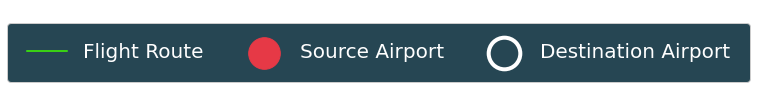

In [182]:
fig, ax = plt.subplots(figsize=(1,1))
ax.set_axis_off()

labels = ['Source Airport', 'Destination Airport']
source_airport = ax.scatter([], [], label='Source Airport', marker='o', s=1000, c='#E63946')
destination_airport = ax.scatter([], [], label='Destination Airport', marker='o', s=1000, c='#264653', 
                                 edgecolors='white', linewidths=4)

# norm = plt.Normalize(0, 1)
# lc = LineCollection([], norm=norm, cmap='viridis')
# lc.set_array(np.array([]))
# flight_route = ax.add_collection(lc)
# flight_route.set_label('Hello')

flight_route = ax.plot([], [], label='Flight Route', c='#40ff00')

legend = ax.legend(borderpad=1, ncol=3, prop={'size': 20}, borderaxespad=0.8, 
                   loc='upper center', facecolor='#264653', framealpha=1,
                   labelcolor='white')

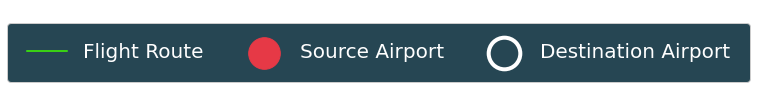

In [183]:
route = pdk.Layer(
    "GreatCircleLayer",
    df_plot,
    pickable=True,
    get_stroke_width=500,
    get_source_position=['longitude_deg_source', 'latitude_deg_source'],
    get_target_position=['longitude_deg_destination', 'latitude_deg_destination'],
    get_source_color=[64, 255, 0],
    get_target_color=[0, 128, 200],
    auto_highlight=True,
    on_drag=False
)

radius_units = 'meter'
point_source = pdk.Layer(
    "ScatterplotLayer",
    df_plot.drop_duplicates(subset='name_source'),
    radius_units=radius_units,
    pickable=True,
    opacity=0.5,
    stroked=False,
    filled=True,
    radius_scale=100,
    line_width_min_pixels=1,
    get_position=['longitude_deg_source', 'latitude_deg_source'],
    get_radius=1200,
    get_fill_color=[230, 57, 70],
)

point_dest = pdk.Layer(
    "ScatterplotLayer",
    df_plot.drop_duplicates(subset='name_destination'),
    radius_units=radius_units,
    pickable=True,
    opacity=0.5,
    stroked=True,
    filled=False,
    radius_scale=100,
    line_width_min_pixels=1.5,
    get_position=['longitude_deg_destination', 'latitude_deg_destination'],
    get_radius=1200,
    get_line_color=[255, 255, 255]
)

# Set the viewport location
view_state = pdk.ViewState(latitude=50, longitude=0, zoom=1,
                           bearing=0, pitch=0, min_zoom=1)
# view_state = pdk.data_utils.compute_view(df_plot[['longitude_deg_destination', 'latitude_deg_destination']])

# Render
r = pdk.Deck(layers=[route, point_source, point_dest], initial_view_state=view_state, tooltip={"text": "{name_source} to {name_destination}"},)
r.picking_radius = 10

# Show the legend first before showing the map
display(fig)
r.to_html('great_circle_layer.html')

Awesome! Now, we have flight route for large airport in the world along with markers denoting source and destination airport.

# Takeaways

Pydeck is a great library for geospatial data visualization. This flight route project is simply one of the great features pydeck has to offer. Another plotting that pydeck able to do that really interests me is GeoJSONLayer and ColumnLayer which enables you to create column visualization on top of map. This could be great thing for many cases of geospatial visualization, such as visualizing the house prices in a city based on each district/county. But, pydeck also lack some features that we needed most, like adding legends to give more context about the graph to the viewers. Hopefull, they will add more amazing features in the future!